# Importing Libraries

In [ ]:
# Importing all the requied libraries , which I used in this Project.
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential,Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm
from keras import optimizers
from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [ ]:
# That's are my model path directories 
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16_fine_tuned")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [ ]:
# Using condition to confirm that have all above defined directories are their or not 
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

As a result, a csv file will be created containing the locations of the training and test images, and their associated classes, if present, so that the data can be traced easily.

In [ ]:
# Use pandas library to read csv file of training and testing data set.
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

## Converting into numerical values

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16_fine_tuned.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c5': 0, 'c9': 1, 'c1': 2, 'c4': 3, 'c7': 4, 'c2': 5, 'c0': 6, 'c3': 7, 'c6': 8, 'c8': 9}
(17462, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [ ]:
# Spliting each data train and test into two parts .
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████████████████████████████████████████████████████████████████████████| 3493/3493 [00:51<00:00, 67.93it/s]


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [ ]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# train_vgg16 = model.predict(train_tensors,verbose=1)
# valid_vgg16 = model.predict(valid_tensors,verbose=1)

In [ ]:
# print("Train shape",train_vgg16.shape)
# print("Validation shape",valid_vgg16.shape)

In [ ]:
# train_features = train_vgg16[0]
# valid_features = valid_vgg16[0]

In [ ]:
# print("Train features shape",train_features.shape)
# print("Validation features shape",valid_features.shape)

# Model Architecture

In [ ]:
# base_model = VGG16(include_top=False)
# base_model.summary()

In [ ]:
model.output_shape[1:]

(None, None, 512)

In [ ]:
# To create a model layer-by-layer.
vgg16_model_fine_tuned = Sequential()
vgg16_model_fine_tuned.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
vgg16_model_fine_tuned.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
# Introducing vgg16_model_fine_tuned 
vgg16_model_fine_tuned = Model(inputs = model.input, outputs = vgg16_model_fine_tuned(model.output))

vgg16_model_fine_tuned.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [ ]:
# Applayed condition for model_fine_tuned bt changing layers
for layer in vgg16_model_fine_tuned.layers[:15]:
    layer.trainable = False

In [ ]:
# In this step I have convert python code from string form to code object. 
vgg16_model_fine_tuned.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

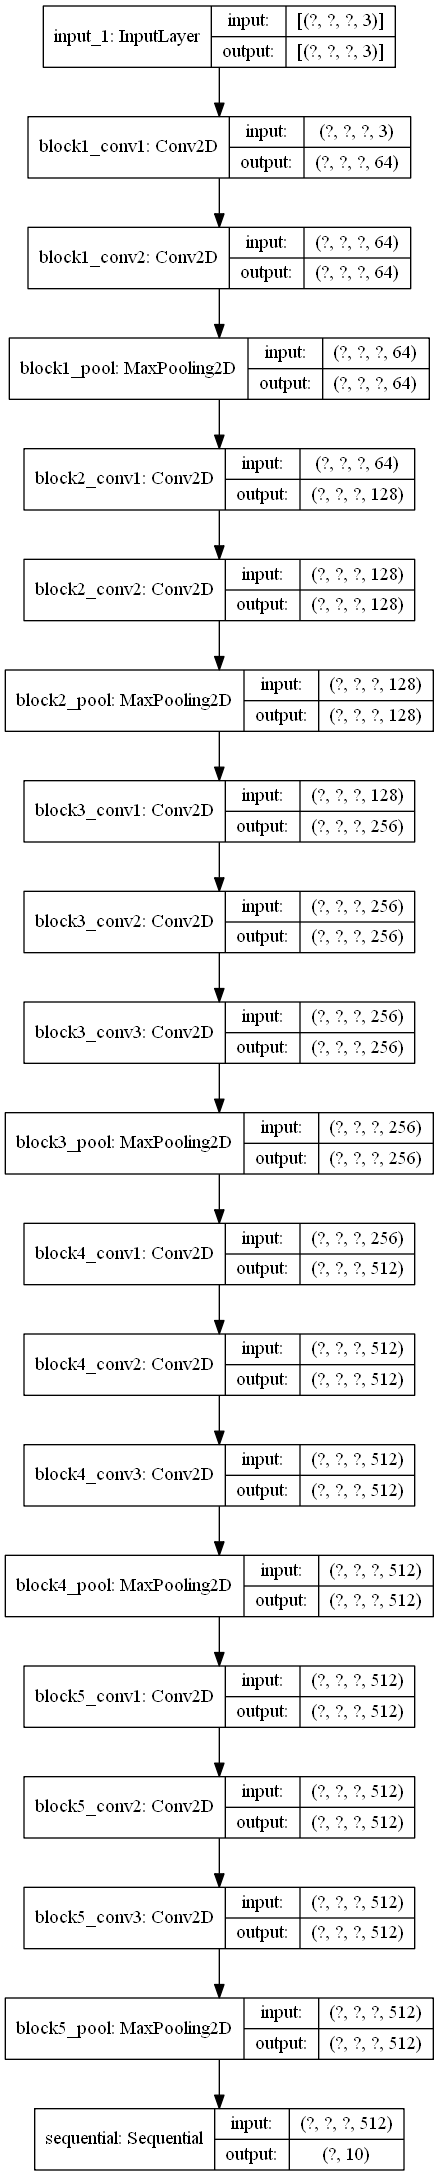

In [ ]:
plot_model(vgg16_model_fine_tuned,to_file=os.path.join(os.getcwd(),"model","vgg16_fine_tuned","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

In [ ]:
# Create a path to save the check point
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
# Creating chekpoint to save and source control combined into a single package.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = vgg16_model_fine_tuned.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
874/874 [==============================] - ETA: 0s - loss: 1.3041 - accuracy: 0.5819
Epoch 00001: val_accuracy improved from -inf to 0.83653, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16_fine_tuned\distracted-01-0.84.hdf5
874/874 [==============================] - 920s 1s/step - loss: 1.3041 - accuracy: 0.5819 - val_loss: 0.5574 - val_accuracy: 0.8365
Epoch 2/25
874/874 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8957
Epoch 00002: val_accuracy improved from 0.83653 to 0.93330, saving model to C:\Users\Engr Amir\Downloads\Distracted-Driver-Detection-master\model\vgg16_fine_tuned\distracted-02-0.93.hdf5
874/874 [==============================] - 932s 1s/step - loss: 0.3735 - accuracy: 0.8957 - val_loss: 0.2574 - val_accuracy: 0.9333
Epoch 3/25
874/874 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9479
Epoch 00003: val_accuracy did not improve from 0.93330
874/874 [=============

874/874 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9999
Epoch 00025: val_accuracy did not improve from 0.99113
874/874 [==============================] - 930s 1s/step - loss: 0.0042 - accuracy: 0.9999 - val_loss: 0.0410 - val_accuracy: 0.9906


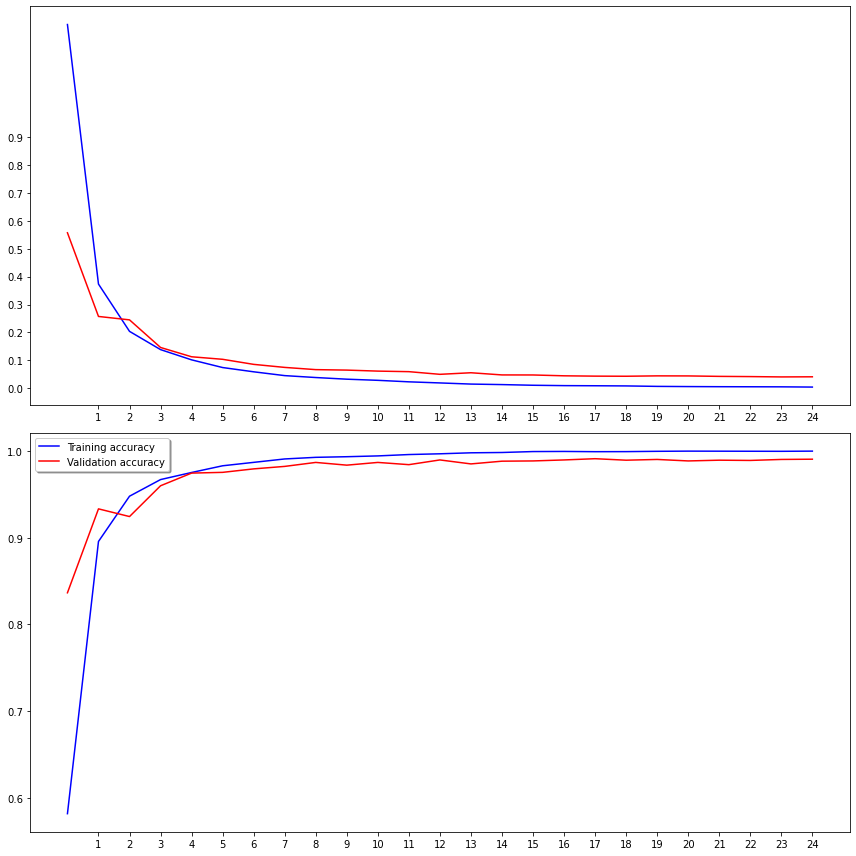

In [ ]:
# displayed comparatively result of train and validation data 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = vgg16_model_fine_tuned.predict(valid_tensors,verbose=1)

110/110 [==============================] - 133s 1s/step


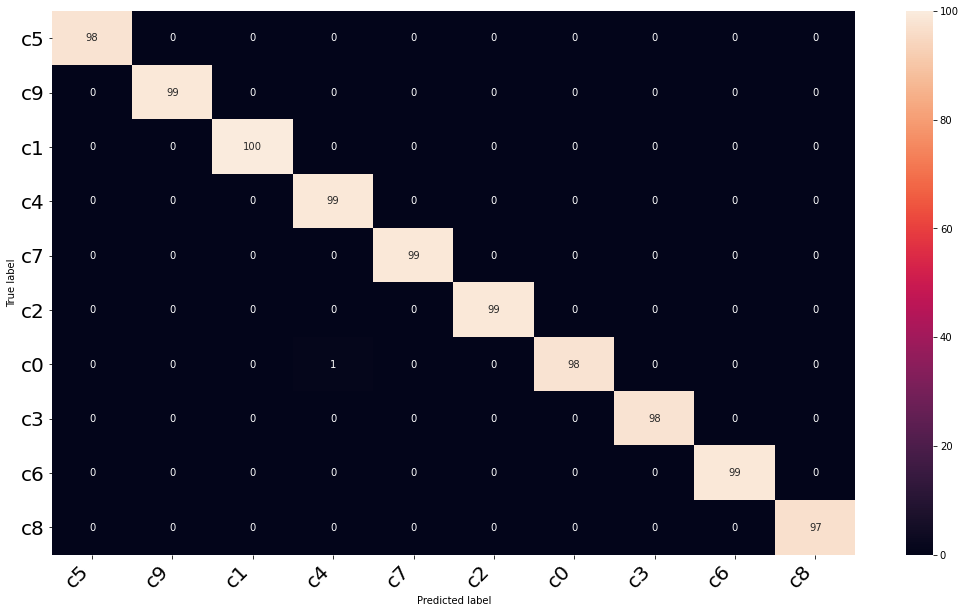

In [ ]:
# Pridicting the accuracy of model by ploting heatmap for True and predicted labels 
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [ ]:
# Indexing the greater class from row with axis = 1 
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
# Indexing the greater number from row with axis = 1 
ytest = np.argmax(ytest,axis=1)

#                 MODEL PERFORMANCE BASED UPON
1 :- positive prediction         
2 :- actual positive value

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.990553
Precision: 0.990580
Recall: 0.990553
F1 score: 0.990552
